In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the file into a DataFrame
df = pd.read_csv('slurm_anon_epyc64_10days', sep='|')

# Display the first few rows of the DataFrame
df.head()

,User,JobID,Submit,Start,End,TimelimitRaw,ElapsedRaw,ReqCPUS,ReqNodes,Account,Partition,QOS,ReqMem,ReqTRES
0,user68,20254931_233,2024-03-14T20:10:51,2024-03-17T18:00:02,2024-03-18T00:01:30,1440,21688,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1"
1,user68,20254931_241,2024-03-14T20:10:51,2024-03-17T18:02:16,2024-03-18T00:01:11,1440,21535,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1"
2,user68,20254931_251,2024-03-14T20:10:51,2024-03-17T18:06:09,2024-03-18T00:05:13,1440,21544,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1"
3,user68,20254931_252,2024-03-14T20:10:51,2024-03-17T18:07:16,2024-03-18T00:00:15,1440,21179,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1"
4,user68,20254931_254,2024-03-14T20:10:51,2024-03-17T18:07:16,2024-03-18T00:10:29,1440,21793,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1"


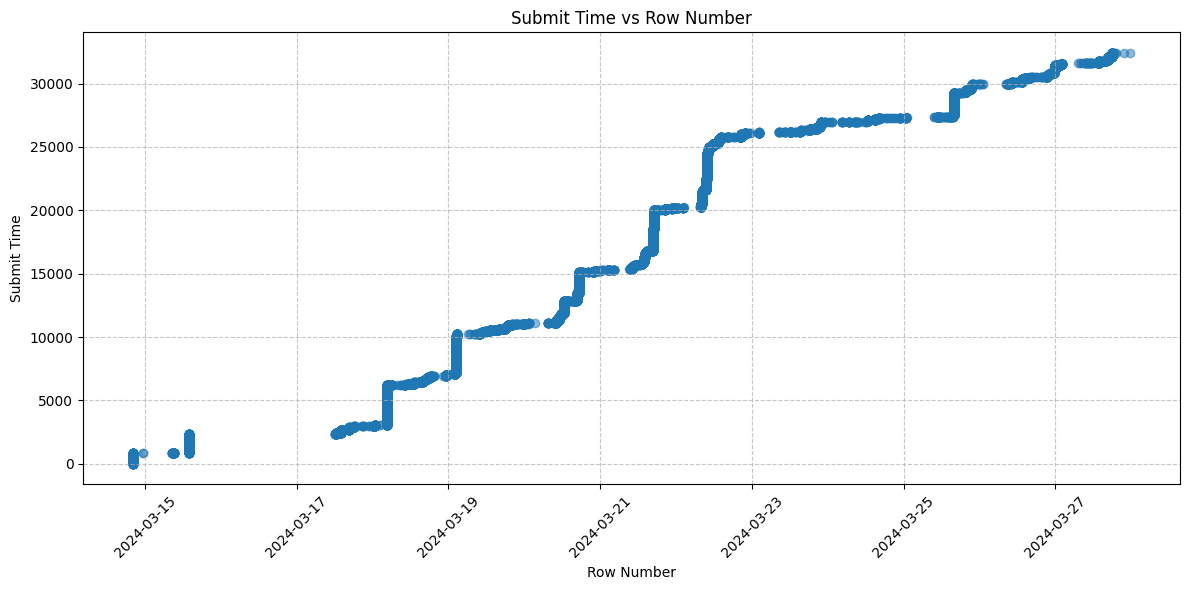

In [2]:
# Convert 'Submit' column to datetime if not already done
df['Submit'] = pd.to_datetime(df['Submit'])

# Create a new column for row numbers
df['Row_Number'] = range(len(df))

# Create the plot
plt.figure(figsize=(12, 6))
plt.scatter(df['Submit'],df['Row_Number'], alpha=0.5)
plt.xlabel('Row Number')
plt.ylabel('Submit Time')
plt.title('Submit Time vs Row Number')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
# Group by 'User'
grouped = df.groupby('User')

# Get unique 'Account' values for each user
unique_accounts = grouped['Account'].unique()

# Convert the unique accounts to a comma-separated string
user_accounts = unique_accounts.apply(lambda x: ', '.join(x))

# Reset the index to turn the Series into a DataFrame
user_accounts = user_accounts.reset_index()

# Print the result
print(user_accounts)

        User               Account
0      user1             account78
1     user10              account7
2    user100             account68
3    user101             account80
4    user102             account86
..       ...                   ...
120   user95             account47
121   user96             account67
122   user97             account55
123   user98             account48
124   user99  account17, account18

[125 rows x 2 columns]


In [16]:
# Generate the commands
commands = []

for _, row in user_accounts.iterrows():
    user = row['User']
    accounts = row['Account'].split(', ')
    for account in accounts:
        commands.append(f"sudo groupadd {account}")
        commands.append(f"sudo useradd -m -g {account} {user}")

# Remove duplicate groupadd commands
unique_commands = list(dict.fromkeys(commands))

# Print the commands into a file called create_users_and_groups.sh
with open('create_users_and_groups.sh', 'w') as file:
    for command in unique_commands:
        file.write(command + '\n')


In [17]:
#Consider the first submit time as the reference time!
# Convert the 'Submit' column to datetime
df['Submit'] = pd.to_datetime(df['Submit'])

# Calculate the real duration of each job
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])
df['Duration'] = (df['End'] - df['Start']).dt.total_seconds()

# Calculate the requested walltime (in seconds)
df['RequestedWalltime'] = df['TimelimitRaw'] * 60


#=== Get the reference time (first submit time) ===#
reference_time = df['Submit'].iloc[0]

# Initialize the TimeDiff column
df['TimeDiff'] = 0.0

# Calculate time difference for each row
for i in range(len(df)):
    if i == 0:
        # First row: Time difference from the reference time
        df.loc[i, 'TimeDiff'] = (df['Submit'].iloc[i] - reference_time).total_seconds()
    else:
        # For all other rows: Time difference from the previous row's Submit time
        df.loc[i, 'TimeDiff'] = (df['Submit'].iloc[i] - df['Submit'].iloc[i-1]).total_seconds()


In [18]:
# Print the number of rows before any processing
print(f"Number of rows before processing: {len(df)}")

# Check for NaT values in each datetime column
for column in ['Submit', 'Start', 'End']:
    nat_count = df[column].isna().sum()
    print(f"Number of NaT values in {column} column: {nat_count}")

# Remove rows with NaT in any of the datetime columns
df_clean = df.dropna(subset=['Submit', 'Start', 'End'])

# Reset the index after dropping rows
df_clean = df_clean.reset_index(drop=True)

# Print the number of remaining rows
print(f"Number of rows after removing all NaT values: {len(df_clean)}")

Number of rows before processing: 32429
Number of NaT values in Submit column: 0
Number of NaT values in Start column: 4809
Number of NaT values in End column: 0
Number of rows after removing all NaT values: 27620


In [19]:
df_clean

,User,JobID,Submit,Start,End,TimelimitRaw,ElapsedRaw,ReqCPUS,ReqNodes,Account,Partition,QOS,ReqMem,ReqTRES,Row_Number,Duration,RequestedWalltime,TimeDiff
0,user68,20254931_233,2024-03-14 20:10:51,2024-03-17 18:00:02,2024-03-18 00:01:30,1440,21688,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1",0,21688.0,86400,0.0
1,user68,20254931_241,2024-03-14 20:10:51,2024-03-17 18:02:16,2024-03-18 00:01:11,1440,21535,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1",1,21535.0,86400,0.0
2,user68,20254931_251,2024-03-14 20:10:51,2024-03-17 18:06:09,2024-03-18 00:05:13,1440,21544,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1",2,21544.0,86400,0.0
3,user68,20254931_252,2024-03-14 20:10:51,2024-03-17 18:07:16,2024-03-18 00:00:15,1440,21179,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1",3,21179.0,86400,0.0
4,user68,20254931_254,2024-03-14 20:10:51,2024-03-17 18:07:16,2024-03-18 00:10:29,1440,21793,5,1,account62,epyc-64,normal,25G,"billing=11,cpu=5,mem=25G,node=1",4,21793.0,86400,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27615,user86,20509425,2024-03-27 17:55:36,2024-03-28 02:14:08,2024-03-28 02:14:10,600,2,192,1,account45,epyc-64,normal,248G,"billing=254,cpu=192,mem=248G,node=1",32422,2.0,36000,2.0
27616,user86,20509428,2024-03-27 17:55:48,2024-03-28 02:14:41,2024-03-28 02:14:45,600,4,192,1,account45,epyc-64,normal,248G,"billing=254,cpu=192,mem=248G,node=1",32423,4.0,36000,12.0
27617,user117,20509721,2024-03-27 19:16:02,2024-03-27 19:16:11,2024-03-27 22:16:38,180,10827,1,1,account5,epyc-64,normal,16G,"billing=5,cpu=1,mem=16G,node=1",32426,10827.0,10800,1827.0
27618,user99,20521980,2024-03-27 21:39:46,2024-03-27 21:39:57,2024-03-27 23:40:21,120,7224,4,1,account17,epyc-64,normal,8G,"billing=6,cpu=4,mem=8G,node=1",32427,7224.0,7200,8624.0


In [20]:
(df_clean['End'] - df_clean['Start']).dt.total_seconds()

0        21688.0
1        21535.0
2        21544.0
3        21179.0
4        21793.0
          ...   
27615        2.0
27616        4.0
27617    10827.0
27618     7224.0
27619     6616.0
Length: 27620, dtype: float64

___

In [21]:
import os
import re
from datetime import datetime
import pandas as pd

def parse_time(time_str):
    # Parse time strings in both formats
    try:
        return datetime.strptime(time_str, "%a %b %d %H:%M:%S %Z %Y")
    except ValueError:
        return datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%S")

def process_log_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    # Extract User ID
    user_id_match = re.search(r'UserId=(\w+)', content)
    if not user_id_match:
        raise ValueError("Could not extract User ID from log content")
    user_id = user_id_match.group(1)

    # Extract Account ID
    account_id_match = re.search(r'Account=(\w+)', content)
    if not account_id_match:
        raise ValueError("Could not extract Account ID from log content")
    account_id = account_id_match.group(1)

    # Extract Job ID from filename
    job_id_match = re.search(r'slurm_job_(\d+)\.log', file_path)
    if not job_id_match:
        raise ValueError("Could not extract Job ID from filename")
    job_id = job_id_match.group(1)
    
    # Extract times
    end_time_match = re.search(r'Job End Time: (.+)', content)
    submit_time_match = re.search(r'SubmitTime=(.+?) ', content)
    start_time_match = re.search(r'StartTime=(.+?) ', content)
    
    if not end_time_match:
        raise ValueError("Could not find Job End Time")
    if not submit_time_match:
        raise ValueError("Could not find SubmitTime")
    if not start_time_match:
        raise ValueError("Could not find StartTime")
    
    end_time = parse_time(end_time_match.group(1))
    submit_time = parse_time(submit_time_match.group(1))
    start_time = parse_time(start_time_match.group(1))
    
    # Calculate wait time and run time
    wait_time = (start_time - submit_time).total_seconds()
    run_time = (end_time - start_time).total_seconds()
    
    return {
        'User ID': user_id,
        'Account ID': account_id,
        'Job ID': job_id,
        'Submit Time': submit_time,
        'Start Time': start_time,
        'End Time': end_time,
        'Wait Time (s)': wait_time,
        'Run Time (s)': run_time
    }

# Directory containing log files
log_dir = 'data-from-1st-run-26k/log'

# Get all log files and sort them
log_files = sorted([f for f in os.listdir(log_dir) if f.startswith('slurm_job_') and f.endswith('.log')],
                   key=lambda x: int(re.search(r'slurm_job_(\d+)\.log', x).group(1)))

# Process all files
results = []
for log_file in log_files:
    file_path = os.path.join(log_dir, log_file)
    try:
        result = process_log_file(file_path)
        results.append(result)
    except Exception as e:
        print(f"Error processing {log_file}: {str(e)}")

# Create a DataFrame from the results
df_read = pd.DataFrame(results)

# Convert times to datetime format
df_read['Submit Time'] = pd.to_datetime(df_read['Submit Time'])
df_read['Start Time'] = pd.to_datetime(df_read['Start Time'])
df_read['End Time'] = pd.to_datetime(df_read['End Time'])

# Convert Job ID to integer
df_read['Job ID'] = df_read['Job ID'].astype(int)

# Convert User ID and Account ID to strings
df_read['User ID'] = df_read['User ID'].astype(str)
df_read['Account ID'] = df_read['Account ID'].astype(str)

# Ensure Wait Time and Run Time remain as floats (seconds)
df_read['Wait Time (s)'] = df_read['Wait Time (s)'].astype(float)
df_read['Run Time (s)'] = df_read['Run Time (s)'].astype(float)

# Sort the DataFrame by Job ID
df_read = df_read.sort_values('Job ID')

# Display the results
print(df_read)

# Optionally, save to a CSV file
df_read.to_csv('slurm_job_analysis.csv', index=False)

# Print summary of processed files
print(f"\nTotal log files: {len(log_files)}")
print(f"Successfully processed: {len(results)}")
print(f"Failed to process: {len(log_files) - len(results)}")

Error processing slurm_job_869.log: Could not extract User ID from log content
Error processing slurm_job_871.log: Could not extract User ID from log content
Error processing slurm_job_888.log: Could not extract User ID from log content
Error processing slurm_job_901.log: Could not extract User ID from log content
Error processing slurm_job_930.log: Could not extract User ID from log content
Error processing slurm_job_988.log: Could not extract User ID from log content
Error processing slurm_job_1021.log: Could not extract User ID from log content
Error processing slurm_job_1029.log: Could not extract User ID from log content
Error processing slurm_job_1126.log: Could not extract User ID from log content
Error processing slurm_job_2392.log: Could not extract User ID from log content
Error processing slurm_job_2423.log: Could not extract User ID from log content
Error processing slurm_job_11114.log: Could not extract User ID from log content
Error processing slurm_job_11118.log: Could n

In [23]:
df_read

,User ID,Account ID,Job ID,Submit Time,Start Time,End Time,Wait Time (s),Run Time (s)
0,user68,account62,1,2024-09-29 19:20:51,2024-09-29 19:20:51,2024-09-30 01:22:19,0.0,21688.0
1,user68,account62,2,2024-09-29 19:20:51,2024-09-29 19:20:51,2024-09-30 01:19:46,0.0,21535.0
2,user68,account62,3,2024-09-29 19:20:51,2024-09-29 19:20:54,2024-09-30 01:19:59,3.0,21545.0
3,user68,account62,4,2024-09-29 19:20:51,2024-09-29 19:20:54,2024-09-30 01:13:54,3.0,21180.0
4,user68,account62,5,2024-09-29 19:20:51,2024-09-29 19:20:54,2024-09-30 01:24:08,3.0,21794.0
...,...,...,...,...,...,...,...,...
23524,user48,account59,26101,2024-10-07 21:22:28,2024-10-07 21:22:28,2024-10-07 22:04:37,0.0,2529.0
23525,user48,account59,26102,2024-10-07 21:22:33,2024-10-07 21:22:33,2024-10-07 21:44:53,0.0,1340.0
23526,user9,account48,26103,2024-10-07 22:28:06,2024-10-07 22:28:06,2024-10-07 22:28:06,0.0,0.0
23527,user9,account47,26104,2024-10-07 22:30:27,2024-10-07 22:30:27,2024-10-07 22:30:27,0.0,0.0


In [26]:
# Create a new column for row numbers
df['Row Number'] = range(len(df))

# Create the plot
plt.figure(figsize=(12, 6))
plt.scatter(df['Submit Time'], df['Row Number'], alpha=0.5)
plt.xlabel('Submit Time')
plt.ylabel('Row Number')
plt.title('Submit Time vs Row Number')

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

KeyError: 'Submit Time'

<Figure size 1200x600 with 0 Axes>